In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns

#sns.set_palette()
cmap = sns.color_palette('tab10')
importlib.reload(bp)


<module 'Branching_Process' from '/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py'>

In [4]:
Tmax = 200
nsteps = 2*Tmax +1 
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
R_eff = 3
t_lockdown = 30
R_eff_scenarios = [1.1, 1.2, 1.5, 2, 2.5, 3]
R_eff_scenarios = [2*r for r in R_eff_scenarios]

eta = 0.2
eta2 = 0.5
# From FF100 data, Challen et al. 2021 Meta-analysis
gmean = 4.87
gsd = 1.98
alpha = gmean**2 / gsd**2
beta = gsd**2 / gmean


# Define distributions for the lifetime, infectivity profile and population-level transmission rate
# For Crump-Mode-Jagers Process

def lifetime(t, tau):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t, tau):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)


def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)

def Rt(t, R=R_eff):
    return R


def R_lockdown(t, R1 = R_eff, R2 = 1, t_lockdown = 30):
    return R1 * (t<=t_lockdown)  + R2 * (1-(t <= t_lockdown))

def R_constant(t, R=1):
    return 1    

# Define individual offspring distribution

def logarithmic_offspring(z, phi = 0.1):
    return - phi * (np.log(phi + 1 - z) - np.log(phi))

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)


cmj_test = bp.cmj(poisson_offspring, time=time)
cmj_test.set_lifetime_distribution(lifetime)
cmj_test.set_infectiousness_profile(infectiousness)
cmj_test.set_transmission_rate(Rt)
#cmj_test.set_cutoff(80)


cmj_lockdown = bp.cmj(poisson_offspring, time=time)
cmj_lockdown.set_lifetime_distribution(lifetime)
cmj_lockdown.set_infectiousness_profile(infectiousness)
cmj_lockdown.set_transmission_rate(R_lockdown)







def immigration(tau, eta = 0.1):
    return eta*np.exp(-eta*tau)

def intensity_measure(t):
    return R_eff * infectiousness_pdf(t) * (1-lifetime(t, 0)) #* (1-lifetime(t, 0))


R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

R0 is: 1.5000000000000149


In [30]:
scenarios = []

max_pgf = 5000

n_cores = 6
characteristic = 'prev'

pmf_scenarios = []

for i, R in enumerate(R_eff_scenarios):
    # if i == 0:
    #     continue
    cmj = bp.cmj(poisson_offspring, time=time)
    cmj.set_lifetime_distribution(lifetime)
    cmj.set_infectiousness_profile(infectiousness)
    def R_constant(t, r=R):
        return R    
    cmj.set_transmission_rate(R_constant)
    scenarios += [cmj]
    start = timer()
    pmf = bp.pmfft(cmj.pgf_vec, 
                        max_pgf, 
                        count = 'prev',
                        parallel = True,
                        n_cores = n_cores)
    stop = timer()
    
    print('Scenario ' + str(i) + ' finished in ' + str(np.round(stop - start, 2)) + ' seconds!')

    pmf_scenarios += [pmf]
    np.savetxt('./Scenarios/No_Immigration/pmf_R=' + str(R_eff_scenarios[i]/2) + '.csv', pmf)


Scenario 1 finished in 405.87 seconds!
Scenario 2 finished in 409.25 seconds!
Scenario 3 finished in 392.87 seconds!
Scenario 4 finished in 397.95 seconds!
Scenario 5 finished in 401.88 seconds!


In [5]:
pmf_scenarios = []
for i, R in enumerate(R_eff_scenarios):
    pmf = np.genfromtxt('./Scenarios/No_Immigration/pmf_R=' + str(R_eff_scenarios[i]/2) + '.csv')
    pmf_scenarios += [pmf]


In [6]:
fpt_scenarios = []

Zstars = np.zeros(len(pmf_scenarios))
tstars = np.zeros(len(pmf_scenarios))
for i, s in enumerate(pmf_scenarios):
    pmf = pmf_scenarios[i]
    mean = bp.mean_pmf(pmf)
    extinction = pmf[0, :]
    Zstar = 167
    try:
        tstar_idx = np.argwhere(mean >= Zstar)[1][0]#np.argwhere(np.gradient(extinction, time_step)<= 0.0001)[1][0]
    except:
        tstar_idx = -1
    tstar = time[tstar_idx]
    #int(mean[tstar_idx]) + 1
    Zstars[i] = Zstar
    tstars[i] = tstar
    FPT_cdf = bp.FirstPassageTime(pmf, Zstar, time, False)
    fpt_scenarios += [np.gradient(FPT_cdf, time_step)]

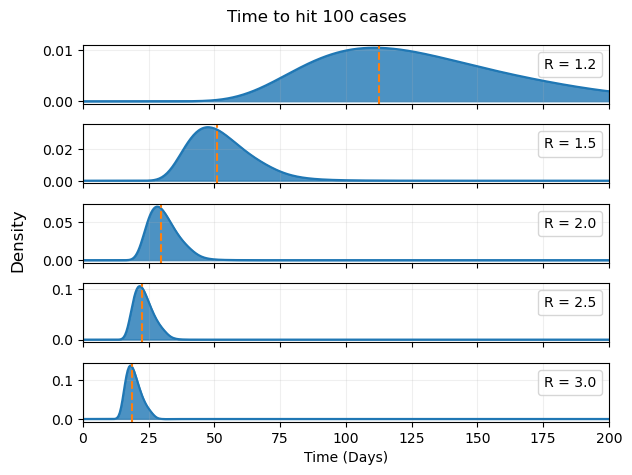

In [14]:
n_scenarios = len(fpt_scenarios)
fig, axs = plt.subplots(nrows = n_scenarios-1, ncols=1)
#fig.set_figwidth(6)

for i in range(n_scenarios-1):
    axs[i].grid(alpha = 0.2)
    axs[i].label_outer()
    
    axs[i].plot(time, fpt_scenarios[i+1], color = cmap[0], label = 'R = ' + str(R_eff_scenarios[i+1]/2))
    axs[i].fill_between(time, fpt_scenarios[i+1], color = cmap[0], alpha = 0.8)
    axs[i].axvline(np.sum(time[1:] * fpt_scenarios[i+1][1:])*time_step, color = cmap[1], linestyle = '--')
    axs[i].axvline()
    axs[i].set_xlim([0, 200])
    
    axs[i].legend(handlelength=0, handletextpad=0, fancybox=True, loc = 'upper right')

plt.xlabel('Time (Days)')
fig.supylabel('Density')
plt.suptitle('Time to hit 100 cases')
plt.tight_layout() 
# plt.savefig('./Figures/scenarios_fpt_popcontrol.pdf')

In [82]:
max_pgf = 5000

n_cores = 6
characteristic = 'prev'

R_lockdowns = np.linspace(1, 2, num = 10)
t_lockdowns = np.arange(10, 100)
extinction_mat = np.zeros((len(R_lockdowns), len(t_lockdowns)))

R = 3
for i, Rl in enumerate(tqdm(np.flip(R_lockdowns))):
    for j, tl in enumerate(t_lockdowns):
        cmj = bp.cmj(poisson_offspring, time=time)
        cmj.set_lifetime_distribution(lifetime)
        cmj.set_infectiousness_profile(infectiousness)
        def R_lockdown(t, R=R, Rl = Rl, t_lockdown = tl):
            return R * (t<=t_lockdown)  + Rl * (1-(t <= t_lockdown))
        cmj.set_transmission_rate(R_lockdown)

        extinction = cmj.extinction_probability(cmj.pgf_vec)
        try:
            extinction_times = time[np.argwhere(extinction >= 0.9)]
            extinction_mat[i, j] = extinction_times[extinction_times >= tl][0]
        except:
            extinction_mat[i, j] = np.Inf

    

100%|██████████| 10/10 [03:46<00:00, 22.66s/it]


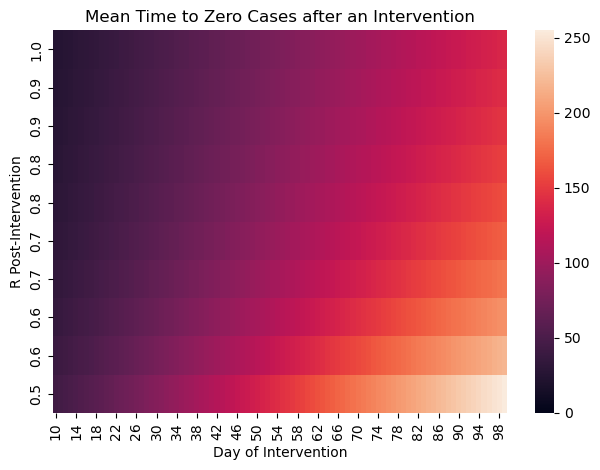

In [333]:
#time[np.argwhere(extinction >= 0.95)]
#plt.plot(time, extinction[:-1])
#tl, extinction_times
extinction_mat[np.isinf(extinction_mat)] = 200
extinction_df = pd.DataFrame(extinction_mat, columns = tl_labels, index = Rl_labels)
ax = sns.heatmap(extinction_df, vmin = 0)
ax.invert_yaxis()
ax.set_xlabel('Day of Intervention')
ax.set_ylabel('R Post-Intervention')
ax.set_title('Mean Time to Zero Cases after an Intervention')
plt.tight_layout()
plt.savefig('./Figures/Time_to_Zero_Intervention_heatmap.pdf')

In [22]:
max_pgf = 5000

n_cores = 6
characteristic = 'prev'

R_l = 1.5
t_lockdowns = np.array((40, 50, 60, 70))
R = 3
lockdown_scenarios = []
extinction_probs = []

for j, tl in enumerate(t_lockdowns[1:]):
    cmj = bp.cmj(poisson_offspring, time=time)
    cmj.set_lifetime_distribution(lifetime)
    cmj.set_infectiousness_profile(infectiousness)
    def R_lockdown(t, R=R, Rl = R_l, t_lockdown = tl):
        return R * (t<=t_lockdown)  + Rl * (1-(t <= t_lockdown))
    cmj.set_transmission_rate(R_lockdown)
    extinction_probs += [cmj.pgf_vec(0)]
    start = timer()
    pmf = bp.pmfft(cmj.pgf_vec, 
                        max_pgf, 
                        count = 'prev',
                        parallel = True,
                        n_cores = n_cores)
    stop = timer()
    

    print('Scenario ' + str(j) + ' finished in ' + str(np.round(stop - start, 2)) + ' seconds!')

    lockdown_scenarios += [pmf]
    

Scenario 0 finished in 464.8 seconds!
Scenario 1 finished in 447.79 seconds!
Scenario 2 finished in 437.77 seconds!


In [8]:
mean_lockdowns = [bp.mean_pmf(ls) for ls in lockdown_scenarios]

def Malthusian_integrand(t, alpha):

    return np.exp(-alpha*t) * lifetime_pdf(t, 0) 

def Malthusian_parameter(alpha):
    return (sp.integrate.quad(Malthusian_integrand, 0, 1000, 
                        args = (alpha))[0] - 1/R0_true)

malpha = sp.optimize.fsolve(Malthusian_parameter, 0.1)
print('malpha is: ' + str(malpha))

malthusian_mean = np.exp(time*malpha)


malpha is: [0.08611122]


Mean at 132.60801095307045


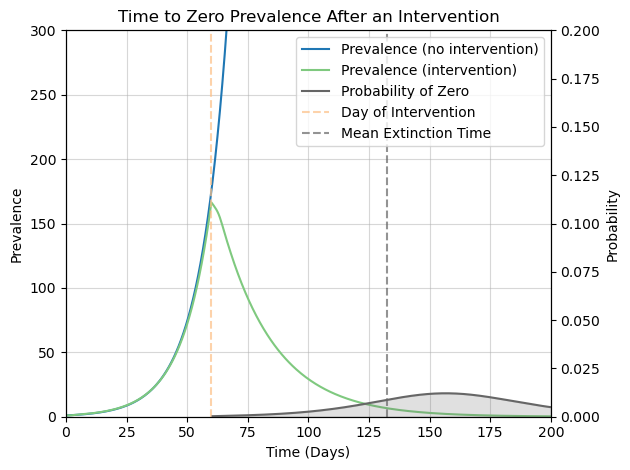

In [21]:
fig, ax = plt.subplots()
ax.grid(alpha = 0.5)
ln1 = ax.plot(time, malthusian_mean, label = 'Prevalence (no intervention)')

l_idx = 2
ls =lockdown_scenarios[l_idx] 
ml = mean_lockdowns[l_idx]
t_idx = np.argwhere(time == t_lockdowns[l_idx])[0][0]
extinction = np.real_if_close(extinction_probs[l_idx][:-1])#ls[0, :-1]
extinction_lockdown = 1 + ((extinction[(t_idx+1):] -1 )/ (1-extinction[t_idx]))
extinction_pdf = np.gradient(extinction_lockdown, time_step)
mean_extinction_time = np.sum(extinction_pdf*time[(t_idx+1):]*time_step)

ln2 = ax.plot(time, ml[:-1], label = 'Prevalence (intervention)', color = cmap[0])
ax.set_xlim([0, 150])
ax.set_ylim([0, 300])
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Prevalence')
ln4 = ax.axvline(time[t_idx], label = 'Day of Intervention', linestyle = '--', alpha = 0.7, color = cmap[2])
ln5 = ax.axvline(mean_extinction_time, label = 'Mean Extinction Time', linestyle = '--', alpha = 0.7, color = cmap[7])
print('Mean at ' + str(mean_extinction_time))

ax2 = ax.twinx()
ln3 =  ax2.plot(time[(t_idx+1):], extinction_pdf, color = cmap[7], label = 'Probability of Zero')
ax2.fill_between(time[(t_idx+1):], 0, extinction_pdf, color = cmap[7], alpha = 0.2)
ax2.set_xlim([0, 200])
ax2.set_ylim([0, 0.2])
ax2.set_ylabel('Probability')
ax.set_title('Time to Zero Prevalence After an Intervention')


lns = ln1+ln2+ln3+[ln4, ln5]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.tight_layout()
#plt.savefig('./Figures/Time_to_Zero_Intervention.pdf')

In [303]:
extinction_list = []
R_lockdowns = np.array((1.2, 1.4, 1.6, 1.8, 2., 2.2))
for j, Rl in enumerate(R_lockdowns):
    cmj = bp.cmj(poisson_offspring, time=time)
    cmj.set_lifetime_distribution(lifetime)
    cmj.set_infectiousness_profile(infectiousness)
    def R_lockdown(t, R=R, Rl = Rl, t_lockdown = 30):
        return R * (t<=t_lockdown)  + Rl * (1-(t <= t_lockdown))
    cmj.set_transmission_rate(R_lockdown)
    extinction = cmj.extinction_probability(cmj.pgf_vec)[:-1]
    extinction_list += [extinction]

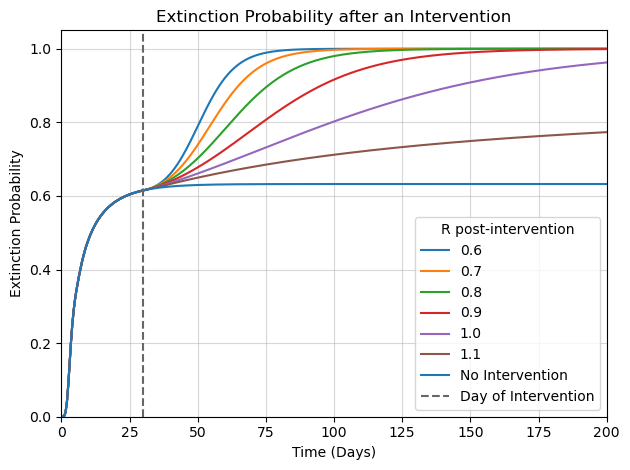

In [349]:

cmj.set_transmission_rate(R_constant)
thresh = 0.95
time_threshs = np.zeros_like(R_lockdowns)

plt.grid(alpha = 0.5)
for j, rl in enumerate(R_lockdowns):
    extinction = extinction_list[j]
    plt.plot(time, extinction, label = str(rl/2))
    try:
        time_threshs[j] = time[np.argwhere(extinction > thresh)[0][0]]
    except:
        time_threshs[j] = np.Inf 
def R_constant(t, r=R):
        return R    
extinction = cmj.extinction_probability(cmj.pgf_vec)[:-1]
plt.plot(time, extinction, label = 'No Intervention', color = 'tab:blue')
plt.axvline(30, linestyle = '--', color = cmap[7], label = 'Day of Intervention')
plt.legend(title = 'R post-intervention')
plt.ylim([0, 1.05])
plt.xlim([0, 200])
plt.ylabel('Extinction Probability')
plt.xlabel('Time (Days)')
plt.title('Extinction Probability after an Intervention')
plt.tight_layout()
#plt.savefig('./Figures/Extinction_Probability_Intervention.pdf')


In [23]:
plt.plot(R_lockdowns, time_threshs)
time_threshs

NameError: name 'R_lockdowns' is not defined

In [ ]:

extinction_mat[np.isinf(extinction_mat)] = 200
extinction_df = pd.DataFrame(extinction_mat, columns = tl_labels, index = Rl_labels)
ax = sns.heatmap(extinction_df, vmin = 0)
ax.invert_yaxis()
ax.set_xlabel('Day of Intervention')
ax.set_ylabel('R Post-Intervention')
ax.set_title('Mean Time to Zero Cases after an Intervention')
plt.tight_layout()